### Important
The code was done on an example dataset. Need to change to the real preprocessed data when available

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import os.path as op
from utils import mkdir_no_exist, make_mask_from_aal

import nibabel as nib
from nilearn import image, datasets
from nilearn.glm import threshold_stats_img
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn.plotting import plot_design_matrix, plot_contrast_matrix, plot_stat_map, plot_roi
from nilearn.image import mean_img

from matplotlib import pyplot as plt

In [2]:
# ACCESS DIRECTORIES #

current_dir = os.path.abspath("")
print(f"current_dir: {current_dir}")
sys.path.append(current_dir)

dataset_id = 'ds000171'
subjects = ['sub-control{:02d}'.format(i+1) for i in range(20)]

dataset_path = os.path.join(current_dir, "data", dataset_id)
deriv_path = os.path.join(current_dir,"data", "derivatives")
preproc_path = os.path.join(deriv_path, 'preprocessed_data')

mkdir_no_exist(dataset_path)
mkdir_no_exist(preproc_path)


current_dir: /data


In [3]:
# READ AND CONCAT EVENTS #

events = {}
for i in range(1,4):
    events[i] = pd.read_csv(os.path.join(dataset_path,subjects[0],"func",f"sub-control01_task-music_run-{i}_events.tsv"), sep = "\t")
    if i>1: #adjust onset time for concatenation
        events[i]['onset'] += (events[i-1]['onset'].iloc[-1] + events[i-1]['duration'].iloc[-1])
        
# for key, event in events.items():
#     display(f"EVENT #{key}\n",event)
events_concat = pd.concat(events.values(),ignore_index=True)
display(events_concat)
events_concat.to_csv(op.join(deriv_path, 'events_concat.csv'))

,onset,duration,trial_type
0,0.0,33.0,tones
1,33.0,3.0,response
2,36.0,31.5,negative_music
3,67.5,3.0,response
4,70.5,31.5,tones
5,102.0,3.0,response
6,105.0,31.5,positive_music
7,136.5,3.0,response
8,139.5,31.5,tones
9,171.0,3.0,response


In [4]:
# ONLY FOR TESTING: need to replace with the preprocessed data
# plotted design matrix is not correct until glm is fit to own data!

from nilearn.datasets import fetch_spm_auditory
subject_data = fetch_spm_auditory()

from nilearn.image import concat_imgs, mean_img
fmri_img = concat_imgs(subject_data.func)

In [5]:
task_music_bold = pd.read_json(op.join(dataset_path, "task-music_bold.json"), typ = 'series')

fmri_glm = FirstLevelModel(t_r = task_music_bold.RepetitionTime, 
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm + derivative',
                           drift_model="cosine",
                           high_pass=.01)

# Fit the model to our design and data
fmri_glm = fmri_glm.fit(fmri_img, events_concat)

# ONLY FOR TESTING: only has 80 scans bcs is fit against example fMRI,
# not the correct dataset
design = fmri_glm.design_matrices_[0]
plot_design_matrix(design,rescale=True, output_file = op.join(deriv_path, 'design_matrix.jpg'))
plt.show()

### Still to do for design matrix
- Discuss if add drift (I think yes)
- Discuss if add derivatives (and dispersions?) of regressors

  Yup it is justified since it captures better different shapes of empirical HRF

  Considerations on overfitting - i think we are very far from what i have understood

### Beta/ Statistical maps of each of the regressors

In [6]:
def condition_vector(position:int, n_regressors:int)->np.array:
    vec = np.zeros((1,n_regressors))
    vec[0,position] = 1
    return vec

n_regressors = design.shape[1]
conditions = {
    col:condition_vector(idx, n_regressors) for idx, col in enumerate(design.columns)
}

In [7]:
# All those that are not covariates
covariates = [key for key, value in conditions.items() if "drift" in key or "constant" in key]
conditions_of_interest = {key: value for key, value in conditions.items() if key not in covariates}

betas_zmap = op.join(preproc_path,'betas_zmap')
mkdir_no_exist(betas_zmap)

cluster_size = 10 #number of voxels for a cluster to be kept
fdr_rate = 0.05 # alpha = 5%

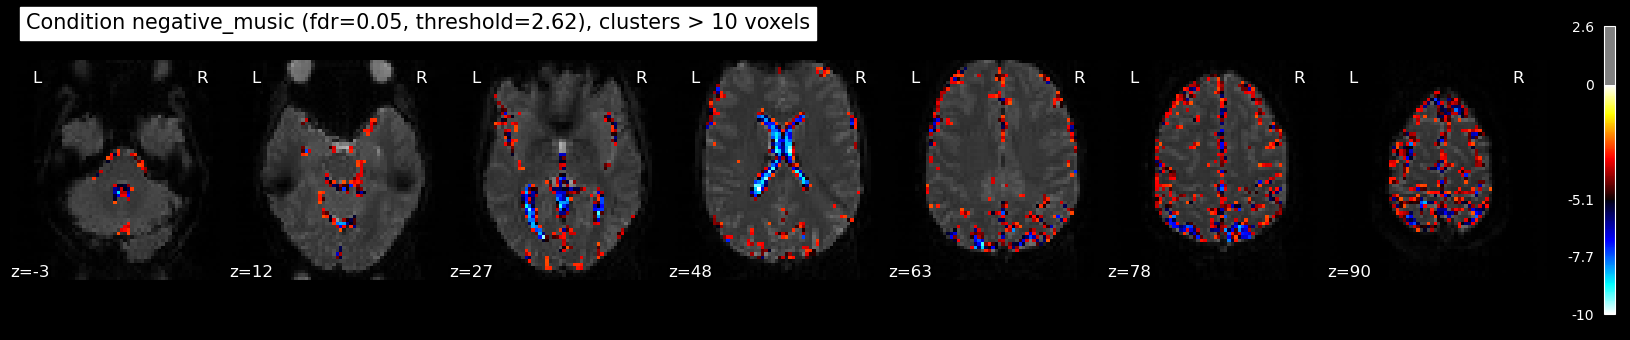

In [8]:
#Plot the statistical map of a single component
key = 'negative_music'
value = conditions_of_interest[key]

z_map = fmri_glm.compute_contrast(value, output_type='z_score')
clean_map, threshold = threshold_stats_img(z_map, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)

mean_img_ = mean_img(fmri_img),
plot_stat_map(clean_map, bg_img=mean_img_[0], threshold=threshold,
              display_mode='z', cut_coords=None, black_bg=True,
              title='Condition {} (fdr={}, threshold={}), clusters > {} voxels'.format(key, fdr_rate, threshold.round(2), cluster_size),
              #output_file = op.join(betas_zmap,f"z_map_fdr5p_cl10_{key}.jpg")
              )
plt.show()

In [ ]:
fig, axs = plt.subplots(len(conditions_of_interest), 1, figsize=(15,40))
for i, (key,value) in enumerate(conditions_of_interest.items()):
    z_map = fmri_glm.compute_contrast(value, output_type='z_score')
    
    # Apply the FDR correction + threshold
    clean_map, threshold = threshold_stats_img(z_map, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)
    
    plot_stat_map(clean_map, bg_img=mean_img_[0], threshold=threshold,
                  display_mode='z', cut_coords=None, black_bg=True,
                  title='Condition {} (fdr={}, threshold={})'.format(key, fdr_rate, threshold.round(2)),
                  axes = axs[i])
fig.suptitle(f"Statistical maps of all regressors (FDR = {fdr_rate} and clusters > {cluster_size})")
plt.show()

### Contrasts

In [9]:
positive_music_position = 2
negative_music_position = 0

pos_vs_neg = conditions['positive_music'] - conditions['negative_music']

plot_contrast_matrix(pos_vs_neg, design_matrix=design, output_file = op.join(deriv_path, 'contrast_pos_neg.jpg'))
plt.show()

/home/jovyan/conda-environments/NX-421/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:308: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)


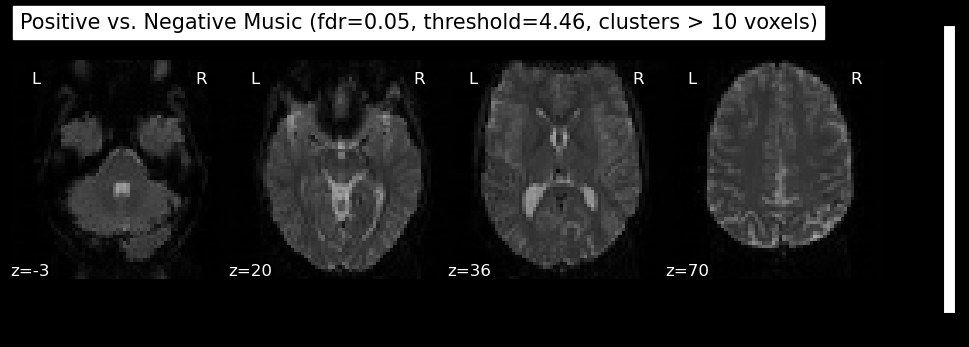

In [10]:
z_map = fmri_glm.compute_contrast(pos_vs_neg, output_type='z_score')
fdr_rate, cluster_size = 0.05, 10
clean_map, threshold = threshold_stats_img(z_map,
                                           alpha=fdr_rate,
                                           height_control='fdr',
                                           cluster_threshold=cluster_size)

mean_img_ = mean_img(fmri_img),
plot_stat_map(clean_map,
              bg_img=mean_img_[0],
              threshold=threshold,
              display_mode='z',
              cut_coords=[-3,20,36,70],
              black_bg=True,
              title='Positive vs. Negative Music (fdr={}, threshold={:.2f}, clusters > {} voxels)'.format(fdr_rate, threshold, cluster_size))
plt.show()

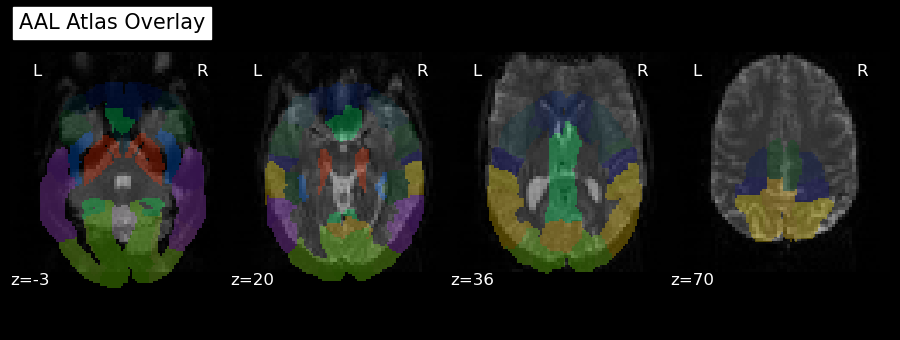

In [11]:
from nilearn import datasets, image

aal_atlas = datasets.fetch_atlas_aal(version='SPM12')
atlas_img = image.load_img(aal_atlas.maps)

# Overlay AAL atlas on top of the fMRI
plot_roi(atlas_img,
          bg_img=mean_img_[0],
          display_mode='z',
          cut_coords=[-3, 20, 36, 70],
          alpha=0.3,
          # resampling_interpolation='continuous', TODOOOO fiiiixxxx
          title="AAL Atlas Overlay")

plt.show()

/home/jovyan/conda-environments/NX-421/lib/python3.9/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


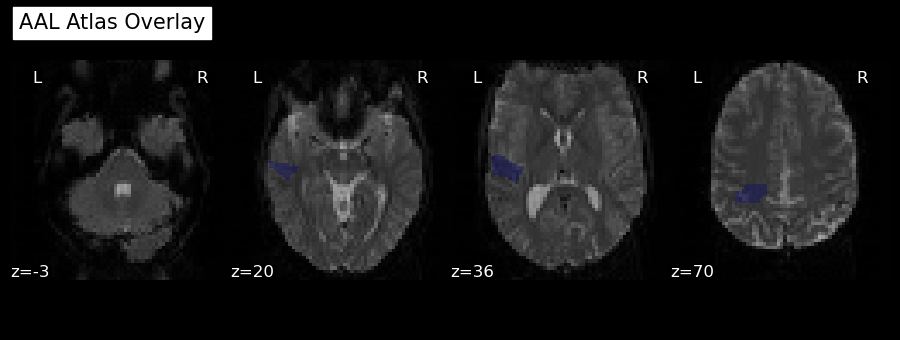

In [13]:
# oooor choose which one

mask_value = 2001  # Replace with the region value from the AAL atlas
mask_name = "mask.nii.gz"  # Name the mask file

make_mask_from_aal(mask_value, mask_name)

# Overlay AAL atlas on top of the fMRI
plot_roi(mask_name,
          bg_img=mean_img_[0],
          display_mode='z',
          cut_coords=[-3, 20, 36, 70],
          alpha=0.3,
          # resampling_interpolation='continuous', TODOOOO fiiiixxxx
          title="AAL Atlas Overlay")

plt.show()


In [15]:
for idx, label in enumerate(aal_atlas.labels):
    print(label, aal_atlas.indices[idx])

Precentral_L 2001
Precentral_R 2002
Frontal_Sup_L 2101
Frontal_Sup_R 2102
Frontal_Sup_Orb_L 2111
Frontal_Sup_Orb_R 2112
Frontal_Mid_L 2201
Frontal_Mid_R 2202
Frontal_Mid_Orb_L 2211
Frontal_Mid_Orb_R 2212
Frontal_Inf_Oper_L 2301
Frontal_Inf_Oper_R 2302
Frontal_Inf_Tri_L 2311
Frontal_Inf_Tri_R 2312
Frontal_Inf_Orb_L 2321
Frontal_Inf_Orb_R 2322
Rolandic_Oper_L 2331
Rolandic_Oper_R 2332
Supp_Motor_Area_L 2401
Supp_Motor_Area_R 2402
Olfactory_L 2501
Olfactory_R 2502
Frontal_Sup_Medial_L 2601
Frontal_Sup_Medial_R 2602
Frontal_Med_Orb_L 2611
Frontal_Med_Orb_R 2612
Rectus_L 2701
Rectus_R 2702
Insula_L 3001
Insula_R 3002
Cingulum_Ant_L 4001
Cingulum_Ant_R 4002
Cingulum_Mid_L 4011
Cingulum_Mid_R 4012
Cingulum_Post_L 4021
Cingulum_Post_R 4022
Hippocampus_L 4101
Hippocampus_R 4102
ParaHippocampal_L 4111
ParaHippocampal_R 4112
Amygdala_L 4201
Amygdala_R 4202
Calcarine_L 5001
Calcarine_R 5002
Cuneus_L 5011
Cuneus_R 5012
Lingual_L 5021
Lingual_R 5022
Occipital_Sup_L 5101
Occipital_Sup_R 5102
Occipita